In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [7]:
transform = transforms.ToTensor()

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])  # for [-1, +1]

mnist_dataset = datasets.MNIST(root="./data",
                               train=True,
                               download=True,
                               transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_dataset,
                                          batch_size=64,
                                          shuffle=True)


In [8]:
data_iter = iter(data_loader)
images, labels = data_iter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


## Linear AutoEncoder

In [12]:
class Autoencoder(nn.Module):

    def __init__(self):

        super().__init__()
        # N X 784 --> N X 3
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        # N X 3 --> N X 784
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# tanh will be used if data is normalized to range -1 to +1

In [19]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)

cuda


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [21]:
# training
num_epochs = 10
outputs = []

for epoch in range(num_epochs):

    for (img, _) in data_loader:

        optimizer.zero_grad()

        img = img.reshape(-1, 28*28).to(device)
        recon = model(img)

        loss = criterion(recon, img)
        loss.backward();
        optimizer.step()

    print(f"Epoch : {epoch+1}, Loss : {loss.item():.4f}")
    outputs.append((epoch, img, recon))

Epoch : 1, Loss : 0.0489
Epoch : 2, Loss : 0.0454
Epoch : 3, Loss : 0.0443
Epoch : 4, Loss : 0.0424
Epoch : 5, Loss : 0.0439
Epoch : 6, Loss : 0.0397
Epoch : 7, Loss : 0.0424
Epoch : 8, Loss : 0.0434
Epoch : 9, Loss : 0.0391
Epoch : 10, Loss : 0.0392


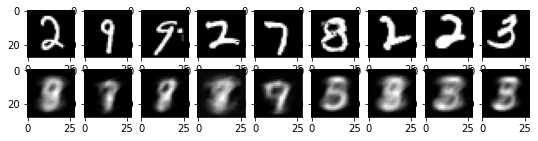

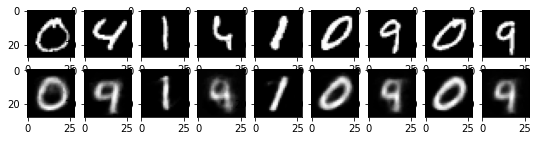

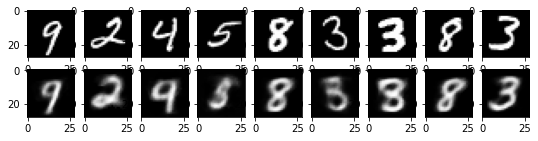

In [24]:
for k in range(0, num_epochs, 4):

    plt.figure(figsize=(9, 2))
    plt.gray()

    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()

    for i, item in enumerate(imgs):
        if i>=9 :
            break

        plt.subplot(2, 9, i+1)
        # 784, --> 1 X 28 X 28
        item = item.reshape(-1, 28, 28)

        plt.imshow(item[0])

    for i, item in enumerate(recon):

        if i>=9:
            break

        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

## CNN AutoEncoder

In [34]:
class CNN_Autoencoder(nn.Module):

    def __init__(self):

        super().__init__()

        self.encoder = nn.Sequential(
            # N X 1 X 28 X 28 --> N X 16 X 14 X 14
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            # N X 16 X 14 X 14 --> N X 32 X 7 X 7
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            # N X 32 X 7 X 7 --> N X 64 X 1 X 1
            nn.Conv2d(32, 64, 7)
        )

        self.decoder = nn.Sequential(
            # N X 64 X 1 X 1 --> N X 32 X 7 X 7
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            # N X 32 X 7 X 7 --> N X 16 X 14 X 14 ( after using output_padding else N X 16 X 13 X 13)
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # N X 16 X 14 X 14 --> N X 1 X 28 X 28 ( after using output_padding else N X 1 X 27 X 27 )
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# nn.Conv2d --> nn.ConvTranspose2d
# nn.MaxPool2d --> nn.MaxUnpool2d

In [35]:
model = CNN_Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.to(device)


CNN_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [36]:
# training
num_epochs = 10
outputs = []

for epoch in range(num_epochs):

    for (img, _) in data_loader:

        optimizer.zero_grad()

        img = img.to(device)
        recon = model(img)

        loss = criterion(recon, img)
        loss.backward();
        optimizer.step()

    print(f"Epoch : {epoch+1}, Loss : {loss.item():.4f}")
    outputs.append((epoch, img, recon))

Epoch : 1, Loss : 0.0109
Epoch : 2, Loss : 0.0051
Epoch : 3, Loss : 0.0041
Epoch : 4, Loss : 0.0037
Epoch : 5, Loss : 0.0032
Epoch : 6, Loss : 0.0032
Epoch : 7, Loss : 0.0028
Epoch : 8, Loss : 0.0027
Epoch : 9, Loss : 0.0031
Epoch : 10, Loss : 0.0026


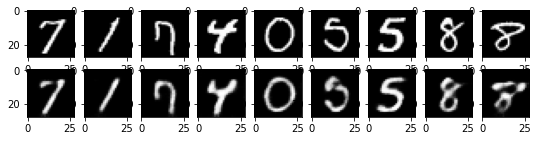

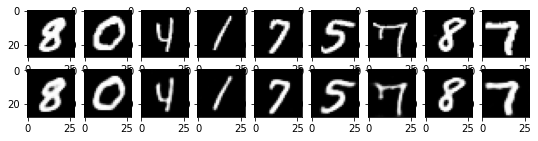

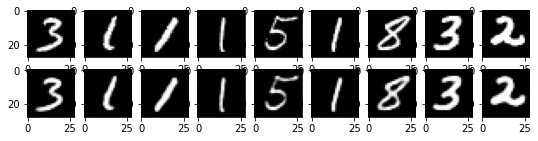

In [37]:
for k in range(0, num_epochs, 4):

    plt.figure(figsize=(9, 2))
    plt.gray()

    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()

    for i, item in enumerate(imgs):
        if i>=9 :
            break

        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):

        if i>=9:
            break

        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])